# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=\Omega_1 \cup \Omega_2$, with $\Omega_1=(0,1)\times(0, 1/4]$ and $\Omega_2=(0,1)\times(1/4,1)$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(0,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-z-1/4, (x,z) \in \Omega_1\\
-4, (x,z) \in \Omega_2
\end{array}
\end{array}
\right., 
\qquad \nu \cdot q = 0 \text{ on } \Gamma_N,
\qquad \psi(t,x,z) = -4 \text{ on } \Gamma_D,
\qquad f = 
\left\{
\begin{array}{ll}
\begin{array}{l} 
0, (x,z) \in \Omega_1\\
0.06 \cos(\frac{4}{3}\pi z) \sin(x), (x,z) \in \Omega_2
\end{array}
\end{array}
\right.
$$
and
$$
\Gamma_{D} = (0,1) \times \{1\},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

import time
from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "/workspaces/richards/")

from richards.model_params import Model_Data
from richards.matrix_computer import Matrix_Computer

from richards.solver import Solver
from richards.solver_params import Solver_Data, Solver_Enum

In [3]:
K = 10000
N = 10
num_steps = 1

eps_psi_abs = 1e-7
eps_psi_rel = 0

domain_tolerance = 1 / (100 * N)

output_directory = 'output_evolutionary'

In [4]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [5]:
theta_r = 0.026
theta_s = 0.42

alpha = 0.551

n = 2.9
K_s = 0.12

T    = 1

In [6]:
h_s = 0
theta_m = theta_s
m = 1 - 1/n

In [7]:
dt   = (T-0)/num_steps

In [8]:
model_data = Model_Data(theta_r=theta_r, theta_s=theta_s, alpha=alpha, n=n, K_s=K_s, T=T, num_steps=num_steps)

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [9]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax1.plot(psi_val, model_data.theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K")

    ax3.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val))
    ax3.set_title("K^-1")

    ax4.plot(psi_val, model_data.theta(psi_val, 1))
    ax4.set_title("d theta / d psi")

    ax5.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val, 1))
    ax5.set_title("d (K) / d psi")

    ax6.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val, 1))
    ax6.set_title("d (K^-1) / d psi")


    plt.show()

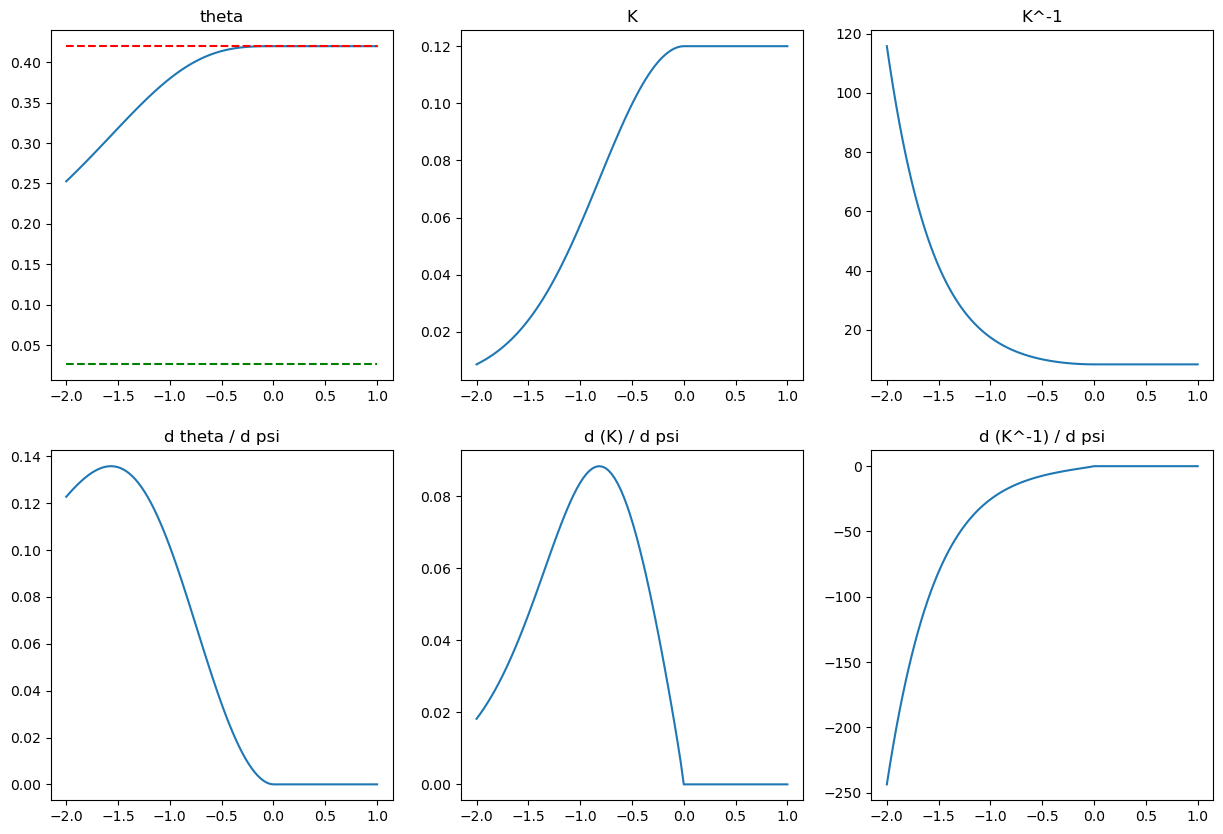

In [10]:
quick_plot()

### Domain preparation

In [11]:
subdomain = pp.StructuredTetrahedralGrid([N, N, N], [1,1,1])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [12]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []
initial_velocity = []

gravity = []

In [13]:
RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [14]:
def g_func(x,t): 
    return np.array([0, 0, -1])

In [15]:
def initial_pressure_func(x):
    if x[1] > 1/4 + domain_tolerance:
        return -4
    else:
        return -x[1]-1/4

In [16]:
def initial_velocity_func(x):
    if x[1] > 1/4 + domain_tolerance:
        return - model_data.hydraulic_conductivity_coefficient(np.array([-4])) * np.array([0,1,1])
    else:
        return np.zeros(shape=3)

In [17]:
def f(x,t):
    res = 0
    if x[1] > 1/4 + domain_tolerance:
        res = 0.06*np.cos(4/3*np.pi*x[1])*np.sin(x[0])

    return res

In [18]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, lambda x: g_func(x,0))
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append( P0.interpolate(subdomain, initial_pressure_func))
    initial_velocity.append(RT0.interpolate(subdomain, initial_velocity_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d  = subdomain.face_centers[1, :] > 1-domain_tolerance
    gamma_n  = gamma_d.copy()
    
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    

    pp.initialize_data(subdomain, data, key, {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
    })
    
    def bc_gamma_d(x): return -4

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, bc_gamma_d, gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool) # No essential BC for pressure
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs))) # Essential BC for velocity on gamma_n

In [19]:
gamma_d.sum(), gamma_n.sum()

(200, 1000)

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi^{n+1}_k) {q^{n+1}_{k+1}} + \nabla \psi^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}_{k+1}} = \frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k}^{n+1}}{\Delta t} + \frac{\theta (\psi^{n}) - \theta (\psi^{n+1}_k)}{\Delta t} + f^{n+1}
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [20]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [21]:
# assemble initial solution
cp = Matrix_Computer(mdg)
initial_solution = np.zeros(cp.dof_q[0] + cp.dof_psi[0])
initial_solution[-cp.dof_psi[0]:] += np.hstack(initial_pressure)

In [22]:
solver_data = Solver_Data(mdg=mdg, initial_solution=initial_solution, scheme=Solver_Enum.NEWTON, bc_essential=lambda t: bc_essential, eps_psi_abs=eps_psi_abs, eps_psi_rel=eps_psi_rel, max_iterations_per_step=K, output_directory=output_directory, L_Scheme_value=0.136, report_name='unsaturated')

solver_data.set_rhs_vector_q(lambda t: np.hstack(list(cond(t) for cond in bc_value)))
solver_data.set_rhs_function_q(g_func)
solver_data.set_rhs_function_psi(f)

In [23]:
solver = Solver(model_data=model_data, solver_data=solver_data)

In [24]:
start = time.time()
solver.solve()
end = time.time()

print('')
print(end - start)

Time 1.0
Iteration #00001, error L2 relative psi:    0.01154680444
Iteration #00002, error L2 relative psi:    0.00764083168
Iteration #00003, error L2 relative psi:    0.00464768179
Iteration #00004, error L2 relative psi:    0.00160613353
Iteration #00005, error L2 relative psi:    0.00033692223
Iteration #00006, error L2 relative psi:    0.00003753949
Iteration #00007, error L2 relative psi:    0.00000021092
Iteration #00008, error L2 relative psi:    0.00000000008

Csv_Exporter: A file with the same name is detected. I'll delete it

25.305805206298828
